## Automated EE stopping via tracking of KLD relative change

In [1]:
%matplotlib inline

# imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import flowkit as fk 
from openTSNE import TSNE

# Pre-processing data 
sample = fk.Sample('data/flow18_annotated.fcs', sample_id='flow18', channel_labels=('Parameter_1', 'Parameter_10', 'Parameter_11', 'Parameter_12', 'Parameter_13', 'Parameter_14', 'Parameter_15', 'Parameter_16', 'Parameter_17', 'Parameter_18', 'Parameter_19', 'Parameter_2', 'Parameter_20', 'Parameter_21', 'Parameter_22', 'Parameter_23', 'Parameter_24', 'Parameter_3', 'Parameter_4', 'Parameter_5', 'Parameter_6', 'Parameter_7', 'Parameter_8', 'Parameter_9', 'SampleID', 'class'))
df_events = sample.as_dataframe(source="raw")

# only use selected columns 
selected_columns = [
    'Parameter_10', 'Parameter_11', 'Parameter_12', 
    'Parameter_13', 'Parameter_15', 'Parameter_18', 'Parameter_20', 
    'Parameter_21', 'Parameter_23', 'Parameter_8', 'Parameter_9', 'class'
]

df_filtered = df_events[selected_columns]
fraction_used = 1.0 

# sample from dataset 
data_sample = df_filtered.sample(frac=fraction_used).reset_index(drop=True)

# get features and labels 
features = data_sample.drop(columns=['class'])  # All columns except 'class'
labels = data_sample['class']  # Only the 'class' column

In [2]:
# step 1: define affinities 
import openTSNE 
affinites = openTSNE.affinity.PerplexityBasedNN(
    features.to_numpy(),
    perplexity=50, 
    n_jobs=-1,
    random_state=12,
    verbose=True
    )

# step 2: define initial embedding 
# init = openTSNE.initialization.pca(features.to_numpy(), random_state=12)
init = openTSNE.initialization.random(n_samples=len(features) ,random_state=12, verbose=True)

# step 3: construct TSNEEmbedding object 
embedding = openTSNE.TSNEEmbedding(
    init, 
    affinites, 
    random_state=12,
    verbose=True
)

===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 797.80 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 338.99 seconds


### Automated EE stopping

In [3]:
from openTSNE import callbacks

class KLDRelativeChangeMonitor(callbacks.Callback):
    def __init__(self, record_every=5):
        """
        Parameters:
            record_every (int): Only check the KL divergence every this many iterations.
        """
        self.record_every = record_every
        self.last_error = None
        self.max_rel_change = -np.inf  # initialize to very small value
        self.kl_divergences = []

    def __call__(self, iteration, error, embedding):
        # Only act at specified iterations.
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))
            if self.last_error is not None:
                # Compute the relative change: (prev_error - current_error) / prev_error
                rel_change = (self.last_error - error) / self.last_error
                print(f"Iteration {iteration}: error = {error:.4f}, relative change = {rel_change:.4f}")
                
                # If the current relative change is greater than any seen before,
                # update our maximum.
                # TODO: let's see whether this stops it way too early
                if rel_change > self.max_rel_change:
                    self.max_rel_change = rel_change
                else:
                    # If the relative change decreases after reaching the maximum,
                    # stop the EE phase.
                    if rel_change + 0.001 < self.max_rel_change: 
                        print("Relative change has decreased after its maximum. "
                          "Stopping early exaggeration.")
                        return True  # Returning True interrupts the optimization.
            # Update last_error
            self.last_error = error
        return False

In [4]:
# Now use the callback during the EE phase.
# Step 4: EE phase (Early Exaggeration)
kld_monitor_EE = KLDRelativeChangeMonitor(record_every=5)
try:
    flow1000_embedding = embedding.optimize(
        n_iter=750, 
        learning_rate=200, 
        exaggeration=12, 
        momentum=0.5, 
        callbacks=kld_monitor_EE, 
        callbacks_every_iters=5, 
        verbose=True
    )
except Exception as e:
    # OptimizationInterrupt is expected when stopping early.
    print("Early Exaggeration phase stopped early:", e)


===> Running optimization with exaggeration=12.00, lr=200.00 for 750 iterations...
Iteration 10: error = 9.7230, relative change = 0.0000
Iteration 15: error = 9.7230, relative change = 0.0000
Iteration 20: error = 9.7230, relative change = 0.0000
Iteration 25: error = 9.7230, relative change = 0.0000
Iteration 30: error = 9.7230, relative change = 0.0000
Iteration 35: error = 9.7230, relative change = -0.0000
Iteration 40: error = 9.7230, relative change = -0.0000
Iteration 45: error = 9.7230, relative change = -0.0000
Iteration 50: error = 9.7230, relative change = -0.0000
Iteration   50, KL divergence 9.7230, 50 iterations in 489.4535 sec
Iteration 55: error = 9.7230, relative change = -0.0000
Iteration 60: error = 9.7230, relative change = -0.0000
Iteration 65: error = 9.7230, relative change = -0.0000
Iteration 70: error = 9.7230, relative change = -0.0000
Iteration 75: error = 9.7230, relative change = -0.0000
Iteration 80: error = 9.7230, relative change = -0.0000
Iteration 85: 

In [5]:
# Step 5: embedding phase of t-SNE (without early exaggeration interruption)
class KLDTracker(callbacks.Callback):
    def __init__(self, record_every=5):
        self.kl_divergences = []
        self.record_every = record_every

    def __call__(self, iteration, error, embedding):
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))
        return False 

kld_tracker_embed = KLDTracker(record_every=5)
flow1000_embedding = flow1000_embedding.optimize(
    n_iter=1500, 
    learning_rate=200, 
    momentum=0.8, 
    callbacks=kld_tracker_embed, 
    callbacks_every_iters=5, 
    verbose=True
)

===> Running optimization with exaggeration=1.00, lr=200.00 for 1500 iterations...
Iteration   50, KL divergence 8.2106, 50 iterations in 375.3747 sec
Iteration  100, KL divergence 7.7951, 50 iterations in 353.6011 sec
Iteration  150, KL divergence 7.5266, 50 iterations in 359.3381 sec
Iteration  200, KL divergence 7.3302, 50 iterations in 357.5107 sec
Iteration  250, KL divergence 7.1755, 50 iterations in 417.0746 sec
Iteration  300, KL divergence 7.0484, 50 iterations in 430.2762 sec
Iteration  350, KL divergence 6.9408, 50 iterations in 412.6830 sec
Iteration  400, KL divergence 6.8478, 50 iterations in 445.3205 sec
Iteration  450, KL divergence 6.7661, 50 iterations in 465.1651 sec
Iteration  500, KL divergence 6.6934, 50 iterations in 364.0999 sec
Iteration  550, KL divergence 6.6280, 50 iterations in 345.6925 sec
Iteration  600, KL divergence 6.5686, 50 iterations in 426.5692 sec
Iteration  650, KL divergence 6.5143, 50 iterations in 412.0405 sec
Iteration  700, KL divergence 6.4

#### Results

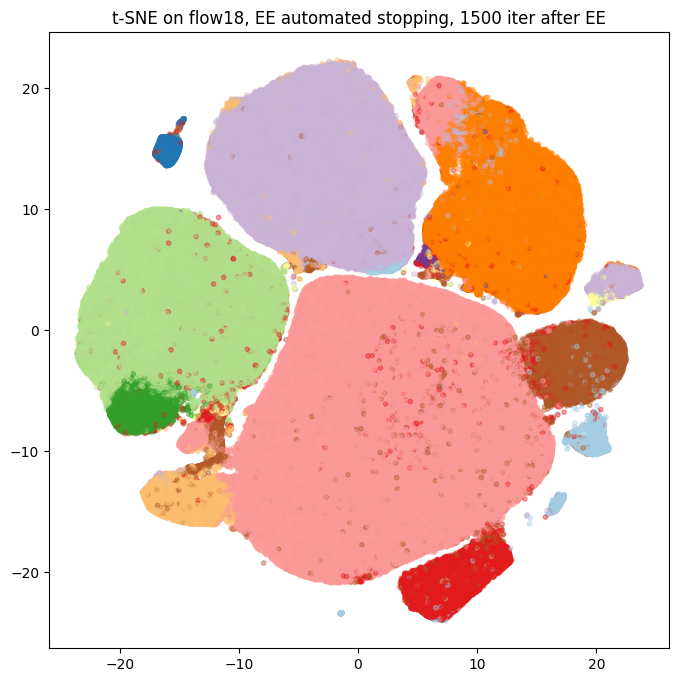

In [8]:
# Final visualization of the t-SNE embedding.
plt.figure(figsize=(8, 8))
plt.scatter(
    flow1000_embedding[:, 0], 
    flow1000_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.4
)
plt.title("t-SNE on flow18, EE automated stopping, 1500 iter after EE")
plt.show()

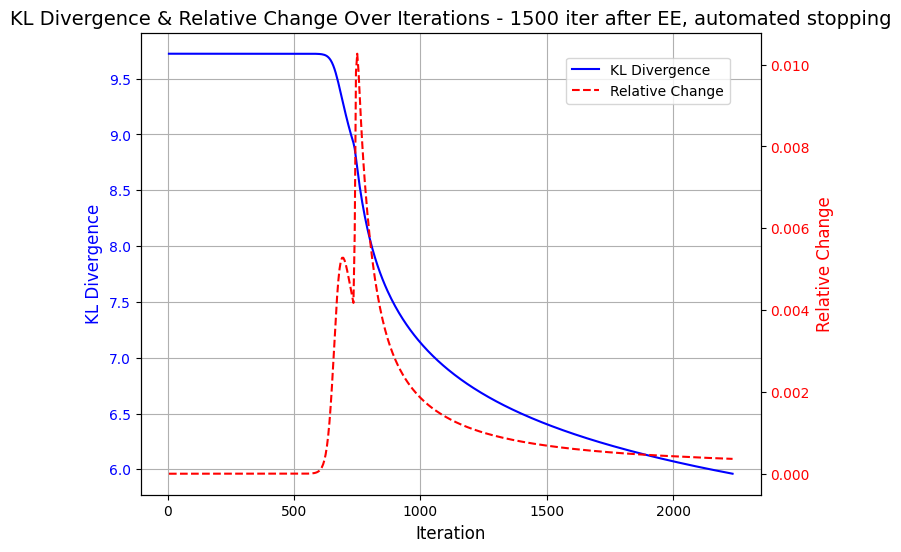

In [10]:
adjusted_divergences = [(iterations + 735, errors) for (iterations, errors) in kld_tracker_embed.kl_divergences]
iterations, errors = zip(*(kld_monitor_EE.kl_divergences + adjusted_divergences))

# Calculate relative change in KL Divergence
errors = np.array(errors)
relative_change = np.zeros_like(errors)
relative_change[1:] = (errors[:-1] - errors[1:]) / errors[:-1]  # Relative change calculation

# Plot KL Divergence and Relative Change
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot KL Divergence
ax1.plot(iterations, errors, linestyle='-', color='b', label='KL Divergence')
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("KL Divergence", fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Secondary y-axis for Relative Change
ax2 = ax1.twinx()
ax2.plot(iterations, relative_change, linestyle='--', color='r', label='Relative Change')
ax2.set_ylabel("Relative Change", fontsize=12, color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legend
plt.title("KL Divergence & Relative Change Over Iterations - 1500 iter after EE, automated stopping", fontsize=14)
fig.legend(loc="upper right", bbox_to_anchor=(0.87, 0.85))

plt.show()

### trying barnes hut algorithm 

In [ ]:
# step 3: construct TSNEEmbedding object 
bh_embedding = openTSNE.TSNEEmbedding(
    init, 
    affinites, 
    negative_gradient_method='bh', 
    theta=0.5, 
    random_state=12,
    verbose=True
)

kld_monitor_EE_bh = KLDRelativeChangeMonitor(record_every=5)
try:
    bh_embedding = bh_embedding.optimize(
        n_iter=750, 
        learning_rate=200, 
        exaggeration=12, 
        momentum=0.5, 
        callbacks=kld_monitor_EE, 
        callbacks_every_iters=5, 
        verbose=True
    )
except Exception as e:
    # OptimizationInterrupt is expected when stopping early.
    print("Early Exaggeration phase stopped early:", e)

kld_tracker_embed_bh = KLDTracker(record_every=5)
bh_embedding = bh_embedding.optimize(
    n_iter=1500, 
    learning_rate=200, 
    momentum=0.8, 
    callbacks=kld_tracker_embed, 
    callbacks_every_iters=5, 
    verbose=True
)

In [ ]:
# Final visualization of the t-SNE embedding.
plt.figure(figsize=(8, 8))
plt.scatter(
    bh_embedding[:, 0], 
    bh_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.4
)
plt.title("t-SNE on flow18, EE automated stopping, 1500 iter after EE")
plt.show()

In [ ]:
adjusted_divergences = [(iterations + 735, errors) for (iterations, errors) in kld_tracker_embed.kl_divergences]
iterations, errors = zip(*(kld_monitor_EE.kl_divergences + adjusted_divergences))

# Calculate relative change in KL Divergence
errors = np.array(errors)
relative_change = np.zeros_like(errors)
relative_change[1:] = (errors[:-1] - errors[1:]) / errors[:-1]  # Relative change calculation

# Plot KL Divergence and Relative Change
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot KL Divergence
ax1.plot(iterations, errors, linestyle='-', color='b', label='KL Divergence')
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("KL Divergence", fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Secondary y-axis for Relative Change
ax2 = ax1.twinx()
ax2.plot(iterations, relative_change, linestyle='--', color='r', label='Relative Change')
ax2.set_ylabel("Relative Change", fontsize=12, color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legend
plt.title("KL Divergence & Relative Change Over Iterations - 1500 iter after EE, automated stopping", fontsize=14)
fig.legend(loc="upper right", bbox_to_anchor=(0.87, 0.85))

plt.show()